# 0. Setup

In [1]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))



In [3]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng()

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


    


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


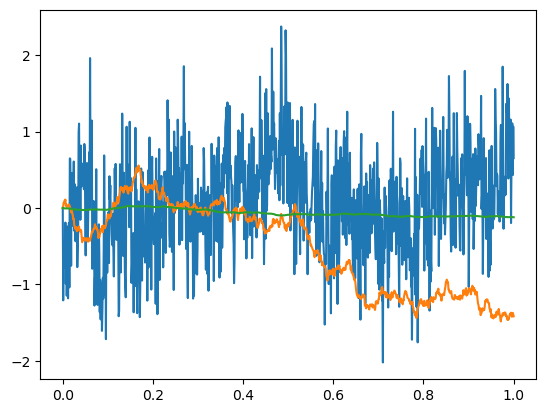

In [4]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

# 1. MLE

In [5]:
#Checking the functionality works - build out in cases where I know what the parameters are

def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 
    


def max_MLE(x, T):
    # Test case where mean, variance known

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    H = minimize(obj, 0.5, args = (diffs, T), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-120)

    if H.success:
        H_hat = H.x
        R = get_covariance_matrix(n_steps, H_hat)
        scalar = (T / n_steps) ** (2 * H_hat)
        R_inv = np.linalg.inv(R) / scalar
        sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        return H_hat, sigma_hat

    return 0

In [19]:
test_sim = simulate_fbm(1, 1024, 1,0.01)
test_sim = 0.5 * test_sim[0, :].T
test_H = max_MLE(test_sim, 1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [20]:
test_H

(array([0.00741109]), 0.49315972169914263)

In [8]:
test_vals = np.arange(0.05, 0.9, 0.05)
errors = np.zeros(test_vals.shape)
for i, val in enumerate(test_vals):
    print(i)
    print(val)
    test_sim = simulate_fbm(1, 1024, 1, val)
    test_sim = test_sim[0, :].T
    test_H = max_MLE(test_sim, 1)
    print(test_H[0])
    errors[i] = test_H[0] - val

errors
    

0
0.05
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instruc

array([ 0.00253147,  0.01790052,  0.01045045, -0.01326246, -0.01793829,
        0.00450027,  0.00857058,  0.01023653,  0.00993649,  0.04534037,
        0.00158034, -0.00730788, -0.05208049,  0.00827491,  0.02069923,
        0.00126924, -0.01109149])

In [9]:
test_H

(array([0.83890851]), 0.9115109092023185)

In [10]:
x = simulate_fbm(1, 1024, 1, 0.3)
x = x[0, :].T

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
obj(0.2, x, 1)

2583.182755638719

In [12]:
max_MLE(x, 1)

(array([0.32611735]), 1.2039005438592005)

In [13]:
sample_fbm = np.loadtxt('/Users/james.male/Dissertation/fBMPath2.txt')
sample_fbm.shape[0]

1024

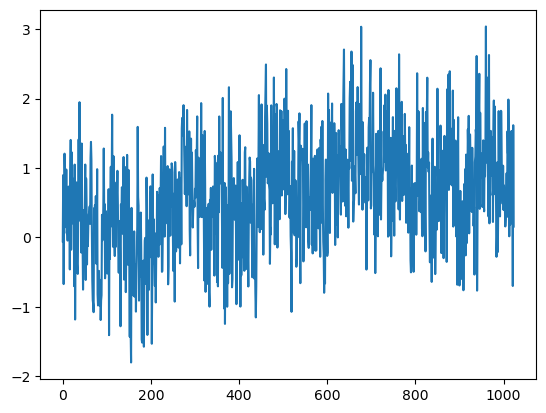

In [14]:
plt.plot(sample_fbm)
